In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir "/content/drive/My Drive/bHapticsML01/data"
!mkdir "/content/drive/My Drive/bHapticsML01/data/Images"


mkdir: cannot create directory ‘/content/drive/My Drive/bHapticsML01/data’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/bHapticsML01/data/Images’: File exists


In [ ]:
#converting pascal voc to the format that darknet needs
import os
import shutil
import numpy as np
import pandas as pd
from xml.etree import ElementTree
import random

base_dir = '/content/drive/My Drive/bHapticsML01/'
countries = ['czech']
classes = ['D00', 'D10','D20', 'D40']

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

for c in countries:
    image_files = sorted(os.listdir(base_dir + c + '/train/images/'))

    for image_file in image_files:
        xml_file = image_file.split('.')[0] + '.xml'
        xml_path = base_dir + c + '/train/annotations/xmls/' + xml_file
        if not os.path.exists(xml_path):
            continue  # Skip processing if corresponding XML file doesn't exist

        infile_xml = open(xml_path)
        tree = ElementTree.parse(infile_xml)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        if root.find('object'):
            objects = []
            for obj in root.iter('object'):
                objects.append(obj.find('name').text)
            if any(i in classes for i in objects):
                file_name = xml_file.split('.')[0]
                out_file = open('/content/drive/My Drive/bHapticsML01/data/Images/' + file_name + '.txt', 'w')
                for obj in root.iter('object'):
                    cls = obj.find('name').text
                    if cls not in classes:
                        continue
                    cls_id = classes.index(cls)
                    xmlbox = obj.find('bndbox')
                    b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                         float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                    bb = convert((w, h), b)
                    out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

                shutil.move(base_dir + c + '/train/images/' + image_file, '/content/drive/My Drive/bHapticsML01/data/Images/')


In [ ]:
import os
import random

# Define the base directory paths
train_dir = '/content/drive/My Drive/bHapticsML01/czech/train/images/'
test_dir = '/content/drive/My Drive/bHapticsML01/czech/test/images/'

# Get image file paths from the train and test directories
train_image_dirs = [train_dir + i for i in os.listdir(train_dir) if os.path.splitext(i)[1].lower() == '.jpg']
test_image_dirs = [test_dir + i for i in os.listdir(test_dir) if os.path.splitext(i)[1].lower() == '.jpg']

print('Total number of train images:', len(train_image_dirs))
print('Total number of test images:', len(test_image_dirs))

# Shuffle the train and test image file paths
random.shuffle(train_image_dirs)
random.shuffle(test_image_dirs)

# Define the number of images for training and testing
num_train = min(len(train_image_dirs), 10000)  # Limit to 10,000 images for training
num_test = len(test_image_dirs)

# Split the dataset into train and test sets
val_split = int(0.1 * num_train)  # 10% of the training set for validation
train_images = train_image_dirs[val_split:num_train]  # Remaining images for training
val_images = train_image_dirs[:val_split]  # First 10% for validation
test_images = test_image_dirs[:]

print('Total number of validation images:', len(val_images))

def list_to_file(dir, my_list):
    with open(dir, 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)

list_to_file('/content/drive/My Drive/bHapticsML01/train.txt', train_images)
list_to_file('/content/drive/My Drive/bHapticsML01/val.txt', val_images)
list_to_file('/content/drive/My Drive/bHapticsML01/test.txt', test_images)


Total number of train images: 1091
Total number of test images: 709
Total number of validation images: 109


In [ ]:
!mv "/content/drive/My Drive/bHapticsML01/obj.names" "/content/drive/My Drive/bHapticsML01/data/"
!mv "/content/drive/My Drive/bHapticsML01/obj.data" "/content/drive/My Drive/bHapticsML01/data/"


In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/My Drive/bHapticsML01/darknet/
!make

/content/drive/My Drive/bHapticsML01/darknet
chmod +x *.sh


In [ ]:
%cd /content/drive/My Drive/bHapticsML01/
!wget https://pjreddie.com/media/files/darknet53.conv.74

/content/drive/My Drive/bHapticsML01
--2024-03-09 16:41:42--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74.1’

darknet53.conv.74.1 100%[===================>] 154.96M  17.2MB/s    in 15s     

2024-03-09 16:41:58 (10.6 MB/s) - ‘darknet53.conv.74.1’ saved [162482580/162482580]



In [ ]:
!cp "/content/drive/My Drive/bHapticsML01/darknet/cfg/yolov3.cfg" "/content/drive/My Drive/bHapticsML01/darknet/cfg/yolo-obj.cfg"

In [ ]:
%cd "/content/drive/My Drive/bHapticsML01/darknet/"
!chmod +x ./darknet  # This gives execute permission to the darknet executable
!./darknet detector train "/content/drive/My Drive/bHapticsML01/data/obj.data" cfg/yolo-obj.cfg "/content/drive/My Drive/bHaptics/yolo/yolo-obj_last.weights" -dont_show


/content/drive/My Drive/bHapticsML01/darknet
 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
train: Using default 'data/train.txt'
valid: Using default 'data/train.txt'
backup: Using default '/backup/'
yolo-obj
mini_batch = 1, batch = 1, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Short

In [ ]:
#val map
%cd "/content/drive/My Drive/bHapticsML01/darknet/"
!./darknet detector map "/content/drive/My Drive/bHapticsML01/data/obj.data" cfg/yolo-obj.cfg "/content/drive/My Drive/bHapticsML01/yolo/yolo-obj_last.weights"

/content/drive/My Drive/bHapticsML01/darknet
 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
Couldn't open file: /content/drive/My Drive/bHapticsML01/data/obj.data


In [ ]:
#test map
%cd "/content/drive/My Drive/bHapticsML01/darknet/"
!./darknet detector map "/content/drive/My Drive/bHapticsML01/data/obj.data" cfg/yolo-obj.cfg "/content/drive/My Drive/bHapticsML01/yolo/yolo-obj_last.weights"

/content/drive/My Drive/bHapticsML01/darknet
 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
Couldn't open file: /content/drive/My Drive/bHapticsML01/data/obj.data


### Inference

In [ ]:
from IPython.display import display, Image

In [ ]:
images = ["/content/drive/My Drive/bHapticsML01/data/Images/Czech_000126.jpg", "/content/drive/My Drive/bHapticsML01/data/Images/Czech_000002.jpg", "/content/drive/My Drive/bHapticsML01/data/Images/Czech_000011.jpg"]


In [ ]:
%cd "/content/drive/My Drive/bHapticsML01/darknet/"
!./darknet detector test "/content/drive/My Drive/bHapticsML01/data/obj.data" /content/darknet/cfg/yolo-obj.cfg \
"/content/drive/My Drive/bHapticsML01/yolo/yolo-obj_last.weights" "/content/drive/My Drive/bHapticsML01/data/Images/Czech_000126.jpg" -dont_show

# Check if predictions.jpg is generated
import os.path
from IPython.display import Image, display

prediction_path = '/content/drive/My Drive/bHapticsML01/darknet/predictions.jpg'
if os.path.isfile(prediction_path):
    display(Image(filename=prediction_path))
else:
    print("Predictions file not found.")


/content/drive/My Drive/bHapticsML01/darknet
 GPU isn't used 
 OpenCV isn't used - data augmentation will be slow 
Couldn't open file: /content/drive/My Drive/bHapticsML01/data/obj.data


In [ ]:
%cd /content/darknet/
!./darknet detector test /content/data/obj.data /content/darknet/cfg/yolo-obj.cfg \
/content/drive/MyDrive/yolo/yolo-obj_last.weights /content/data/Images/India_002894.jpg -dont_show

display(Image(filename='/content/darknet/predictions.jpg'))

/content/darknet
/bin/bash: line 1: ./darknet: Is a directory


FileNotFoundError: [Errno 2] No such file or directory: '/content/darknet/predictions.jpg'

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Sh

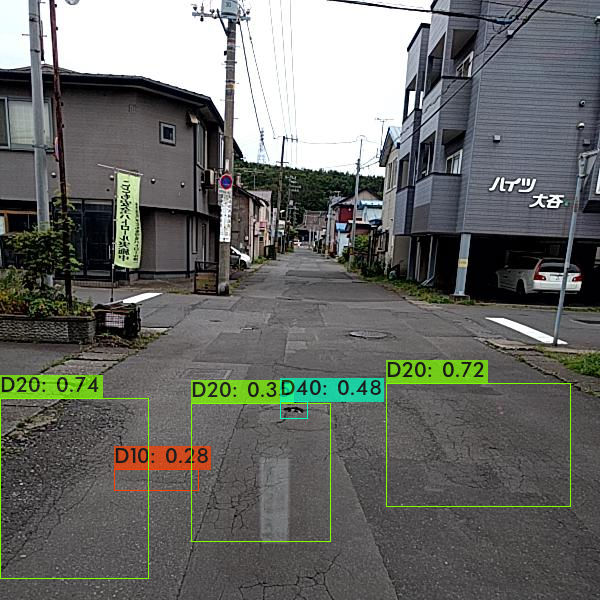

In [ ]:
%cd /content/darknet/
!./darknet detector test /content/data/obj.data /content/darknet/cfg/yolo-obj.cfg \
/content/drive/MyDrive/yolo/yolo-obj_last.weights /content/data/Images/Japan_004720.jpg -dont_show

display(Image(filename='/content/darknet/predictions.jpg'))

In [ ]:
%cd /content/darknet/
!./darknet detector demo /content/obj.data /content/yolo-obj.cfg  \
  /content/drive/MyDrive/yolo/yolo-obj_final.weights /content/drive/MyDrive/input_2.mp4 -dont_show \
  -out_filename '/content/output.avi'

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
  

In [ ]:
!mv /content/output.avi /content/drive/MyDrive/

In [ ]:
%cd /content/data